# Variable Transformations: Why and How and Why not

In short: statistical methods are designed with many assumptions, including that the data that is being used for estimation is normally distributed. However, this is often not the case. Bounded distributions, measurement errors, and different causal mechanisms can produce data that isn't normally distributed. Ask any complexity researcher, (social) network analyst, or systems analyst and they'll tell you about the 80/20 rule and power-law distributions. These kinds of distrubtions abound: the connectivity of websites on the internet, for example, adheres to the 80/20 rule.

![Standard Normal vs. Power Law](normal_v_scale_free.png)

Just to underline the point, let's look at a distribution of the ride times for the Healthy Ride data:

In [1]:
library(ggplot2)
library(RColorBrewer)

In [2]:
# load in data
pghhr.2017.q1 <- read.csv("2017-Q1/Healthy Ride Rentals 2017-Q1.csv")
pghhr.2017.q2 <- read.csv("2017-Q2/Healthy Ride Rentals 2017-Q2.csv")

# combine the data sets
rides = rbind(pghhr.2017.q1, pghhr.2017.q2)

# measure trip lengths in half hour increments
rides$dur.hh = rides$Tripduration / ( 20 * 60 )
head(rides)

Trip.id,Starttime,Stoptime,Bikeid,Tripduration,From.station.id,From.station.name,To.station.id,To.station.name,Usertype,dur.hh
25723960,1/1/2017 8:28,1/1/2017 8:30,70478,110,1043,Coltart Ave & Forbes Ave,1044,Zulema St & Coltart Ave,Subscriber,0.09166667
25724207,1/1/2017 9:53,1/1/2017 10:00,70439,426,1014,Ridge Ave & Brighton Rd (CCAC),1012,North Shore Trail & Fort Duquesne Bridge,Customer,0.35500000
25724297,1/1/2017 10:21,1/1/2017 10:46,70440,1498,1019,42nd St & Butler St,1012,North Shore Trail & Fort Duquesne Bridge,Subscriber,1.24833333
25724391,1/1/2017 11:03,1/1/2017 11:30,70002,1581,1019,42nd St & Butler St,1013,Isabella St & Federal St (PNC Park),Customer,1.31750000
25724479,1/1/2017 11:43,1/1/2017 12:09,70024,1563,1018,37th St & Butler St,1013,Isabella St & Federal St (PNC Park),Customer,1.30250000
25724508,1/1/2017 11:55,1/1/2017 12:23,70195,1647,1018,37th St & Butler St,1013,Isabella St & Federal St (PNC Park),Customer,1.37250000


Warning message:
"Removed 526 rows containing non-finite values (stat_bin)."

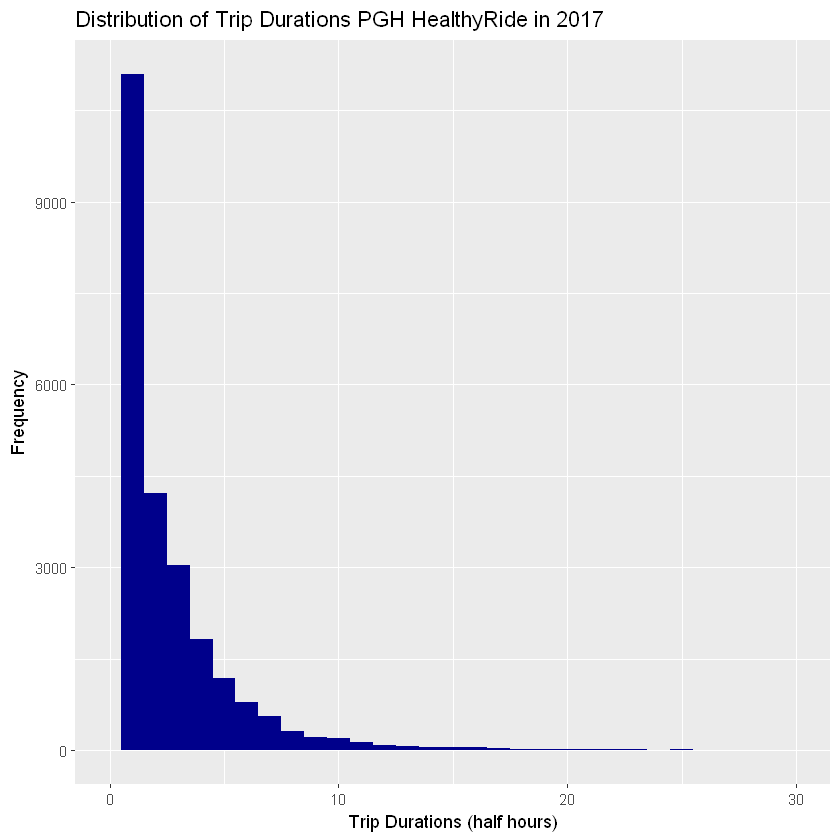

In [3]:
# Histogram of the trip duration for all data

qplot(dur.hh, data = rides, binwidth = 1.0,
      geom = "histogram",
      main = "Distribution of Trip Durations PGH HealthyRide in 2017",
      xlab = "Trip Durations (half hours)",
      ylab = "Frequency",
      xlim = c(0,30),
      fill = I('darkblue'))

This is obviously skewed, and, at this level even looks like a power-law distribution. But, others might not be so obvious. How do we measure this?

## Sample Skewnewss Measurement:

$$ G_1 = \Big(\frac{n^2}{(n-1)(n-2)}\Big) \Big(\frac{m_3}{s^3}\Big) $$

where:
$$ m_3 = \frac{\sum_{i=1}^n(x_i - \bar x)^3}{n} $$

and
$$ s^3 = \Big(\frac{\sum_{i=1}^n(x_i - \bar x)^2}{n - 1}\Big)^{3/2} $$

Source: [Wikipedia](https://en.wikipedia.org/wiki/Skewness)

In [4]:
# skewness in R

# Note: there is no skewness function in the R base package
# You'll need to install one. Two most popular:

# install.packages('moments') ### further note: was not available for R 3.4.1...
# install.packages('e1071')

library(e1071)
skewness(rides$dur.hh)

Warning message:
"package 'e1071' was built under R version 3.4.2"

[1] 7.863117

So now what do we do? If a heavy skew prevents us from using the data, how can we fix it? And what does a heavy skew even look like? How do know what is and isn't heavily skewed?

## Interpreting Skewness and Transformations

| Skew Type | Measurement | Transformation | Transformation Computation |
|:-----|:-----|:-----:|-----|
| Moderate Positive | 0.5 < $sk \le$ 1.0 | sqrt | $X_{new} = \sqrt{X} $ |
| Significant Postivie | 1.0 < $sk \le$ 2.0 | $log_{10}$ | $X_{new} = log_{10}(X) $ |
| Sig. Pos. w/ values < 0 | 1.0 < $sk \le$ 2.0 | $log_{10}$ | $X_{new} = log_{10}(X + C) $ |
| Severe Positive | $sk$ > 2.0 | inverse | $X_{new} = 1 / X $ |
| Svr. Pos. w/ values < 0 | $sk$ > 2.0 | inverse | $X_{new} = 1 / (X + C) $ |
| Moderate Negative | -1.0 $\ge sk$ < -0.5 | reflect and sqrt | $X_{new} = \sqrt{K - X} $ |
| Significant Negative | -2.0 $ \ge sk$ < -1.0 | reflect and $log_{10}$ | $X_{new} = log_{10}(K - X) $ |
| Severe Negative | $sk$ < -2.0 | reflect and inverse | $X_{new} = 1 / (K - X) $ |

**$C$**: a constant such that $C + X_{min} \ge 1$

**$K$**: a constant such that $K - X_{max} = 1$

Source: Mertler & Vanatta, 3rd Edition (2005)

## Some examples of the Transformations in Action

### Positive Skew (Right Skew)

#### Getting a skewed distribution

In [5]:
# need to install the 'sn' package:
# install.packages('sn')

library(sn)

a <- 1000
r.pos <- rsn(n = 10000, alpha = a)
print(paste("skewness: ",
            round(skewness(r.pos), 5)))
print(paste("Minimum value: ",
            min(r.pos)))

Loading required package: stats4

Attaching package: 'sn'

The following object is masked from 'package:stats':

    sd



[1] "skewness:  1.00962"
[1] "Minimum value:  -0.00050201342893061"


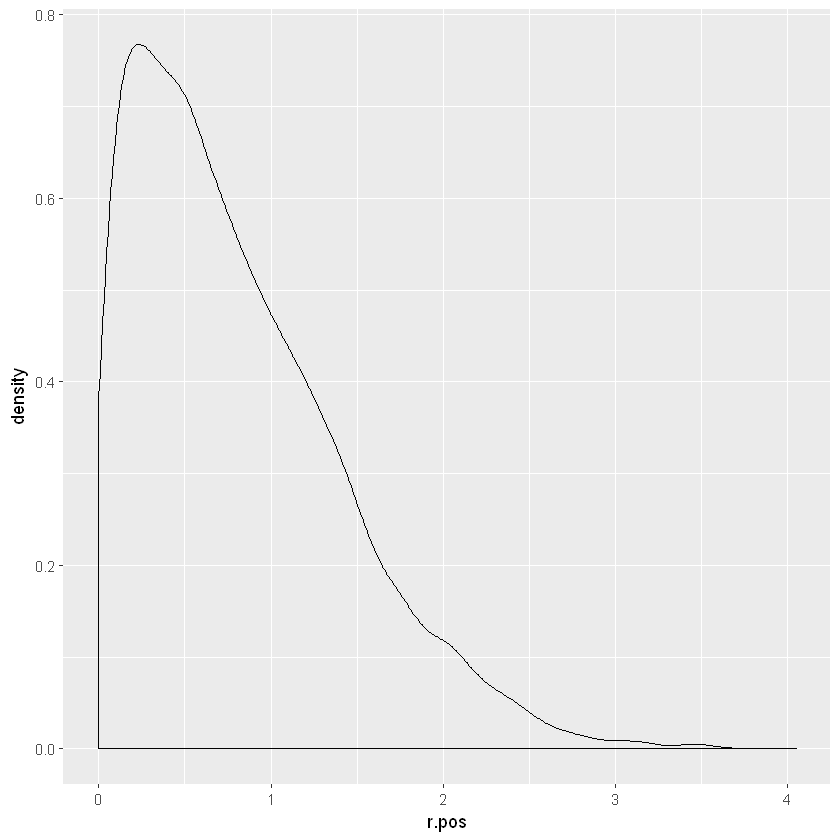

In [6]:
qplot(r.pos, geom = "density")

#### Transforming

[1] "C:  1.0005"
[1] "skewness:  0.640962855481768"


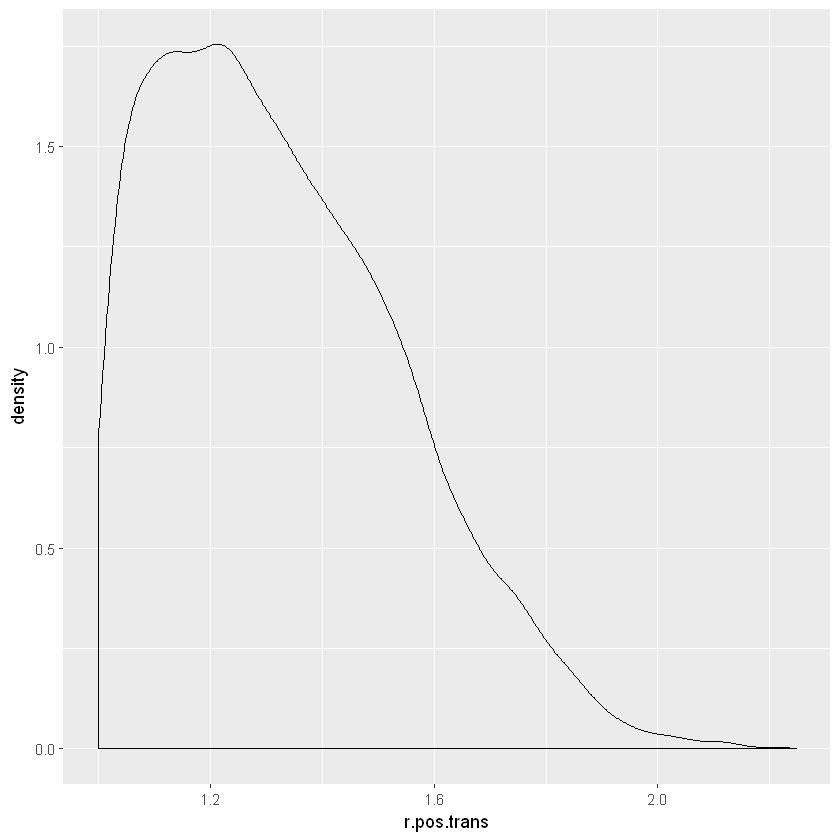

In [7]:
# Since we have a negative above, find C
C <- 1 - min(r.pos)
print(paste("C: ",
            round(C,4)))

# with C calculated, skewnewss was less than 1, therefore, use sqrt
r.pos.trans <- sqrt(C + r.pos)

# find new skewness to test change
print(paste("skewness: ",
            skewness(r.pos.trans)))

# plot histogram to see the change
qplot(r.pos.trans, geom = "density")

[1] "skewness:  0.319581236223375"


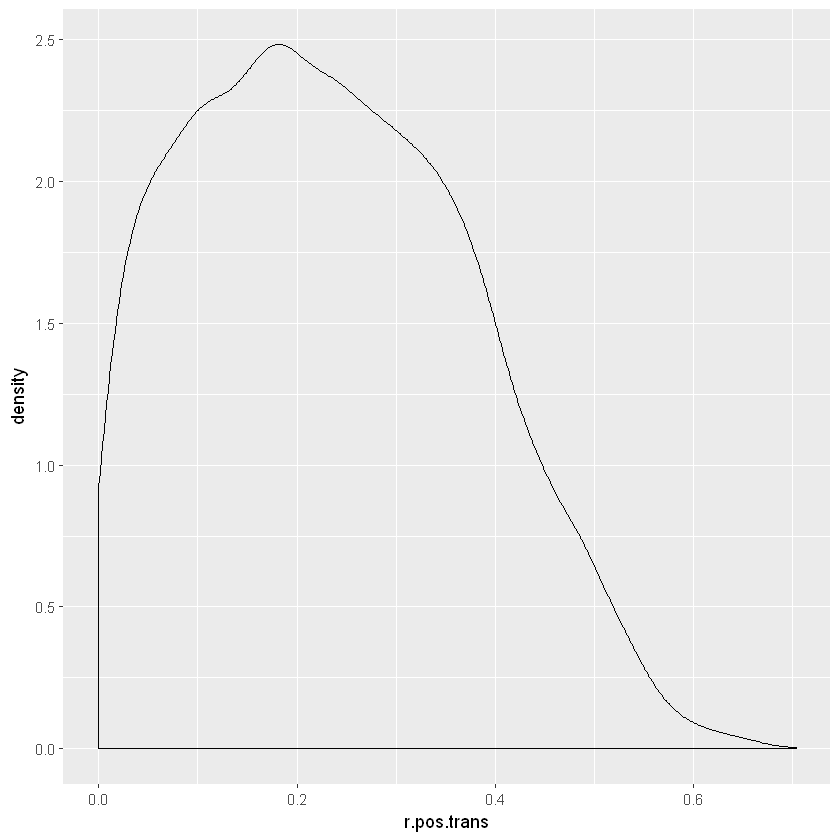

In [8]:
# we improved it, but not very much. Let's try the transformation for greater than 1

# with C calculated, skewnewss was less than 1, therefore, use sqrt
# use the same C
r.pos.trans = log10(C + r.pos)

# find new skewness to test change
print(paste("skewness: ",
            skewness(r.pos.trans)))

# plot histogram to see the change
qplot(r.pos.trans, geom = "density")

### Negative Skew (Left Skew)

#### Getting the distribution

[1] "skewness:  -1.02028"


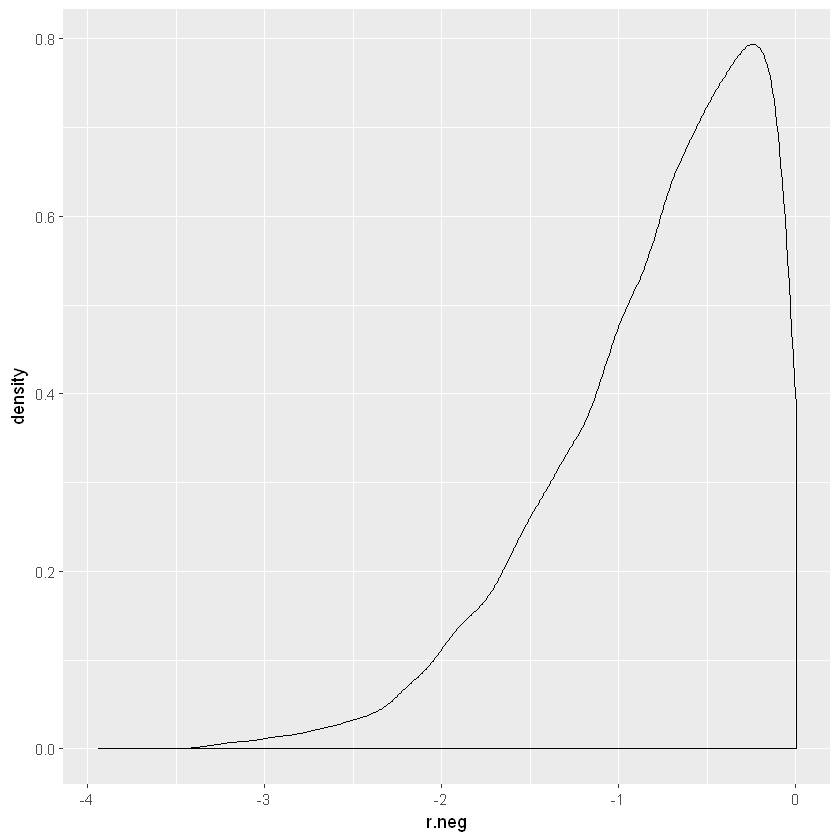

In [9]:
a <- -1000
r.neg <- rsn(n = 10000, alpha = a)
print(paste("skewness: ",
            round(skewness(r.neg), 5)))

qplot(r.neg, geom = "density")

[1] "K:  1.0008"
[1] "skewness:  0.347606625517509"


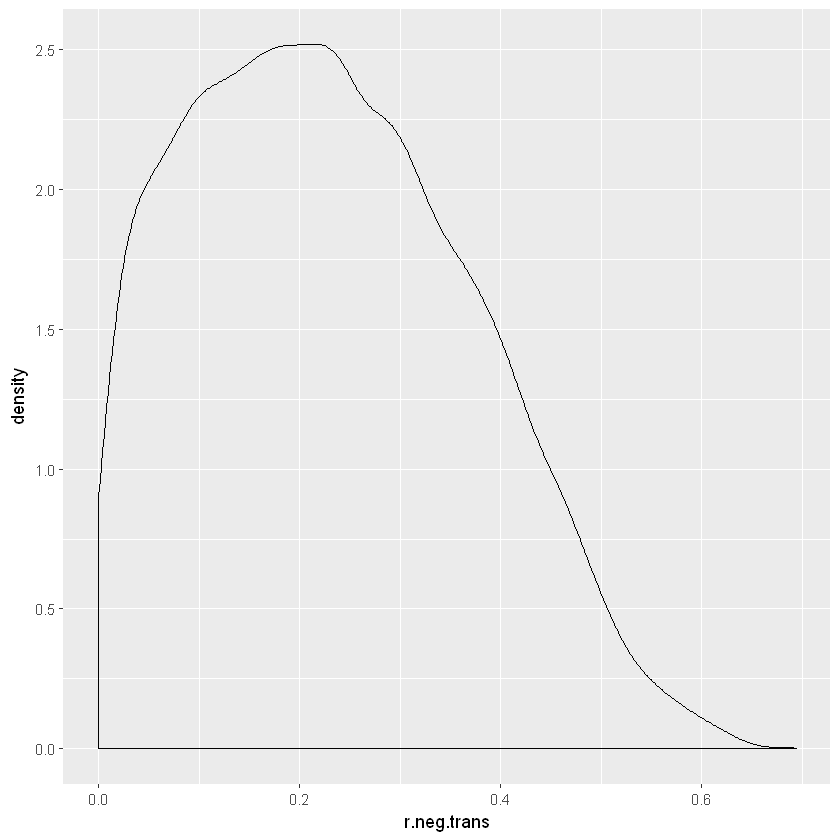

In [10]:
# We need K, since it's a part of every transformation for a negative skew
K = 1 + max(r.neg)
print(paste("K: ",
            round(K, 4)))

# with C calculated, skewnewss was less than 1, therefore, use sqrt
r.neg.trans = log10(K - r.neg)

# find new skewness to test change
print(paste("skewness: ",
            skewness(r.neg.trans)))

# plot histogram to see the change
qplot(r.neg.trans, geom = "density")

So...still not perfect, but good enough to get on with. What's the problem?

Answer: Interpretation.

## Differentiation

Normally, for a regression:
$$ y = \beta_0 + \beta_1x + \epsilon$$

and
$$ \frac{dy}{dx} = \beta_1 $$

simple enough

but now... say you have a moderate positive skew with no values below 0
$$ y = \beta_0 + \beta_1 \sqrt{x} + \epsilon$$

and now
$$ \frac{dy}{dx} = \beta_1 \frac{1}{2\sqrt{x}}$$

Mathematically, this isn't too terrible to use. But, it is difficult to explain and to present to someone else, especially someone who isn't mathematically inclined.

So...updating our table from above:

| Skew Type | Measurement | Transformation | Transformation Computation | Derivative Formula |
|:-----|:-----|:-----:|-----|-----|
| Moderate Positive | 0.5 < $sk \le$ 1.0 | sqrt | $X_{new} = \sqrt{X} $ | $d=1 / \sqrt{x} $ |
| Significant Postivie | 1.0 < $sk \le$ 2.0 | $log_{10}$ | $X_{new} = log_{10}(X) $ | $d=1 / [x ln(10)] $ |
| Sig. Pos. w/ values < 0 | 1.0 < $sk \le$ 2.0 | $log_{10}$ | $X_{new} = log_{10}(X + C) $ | $d=\frac{1}{(x+C)ln(10)} $ |
| Severe Positive | $sk$ > 2.0 | inverse | $X_{new} = 1 / X $ | $d=-1/x^2 $ |
| Svr. Pos. w/ values < 0 | $sk$ > 2.0 | inverse | $X_{new} = 1 / (X + C) $ | $d=\frac{-1}{(X+C)^2}$|
| Moderate Negative | -1.0 $\ge sk$ < -0.5 | reflect and sqrt | $X_{new} = \sqrt{K - X} $ | $d = \frac{1}{\sqrt{K - x}} $ |
| Significant Negative | -2.0 $ \ge sk$ < -1.0 | reflect and $log_{10}$ | $X_{new} = log_{10}(K - X) $ | $d=\frac{1}{(K-x)ln(10)} $ |
| Severe Negative | $sk$ < -2.0 | reflect and inverse | $X_{new} = 1 / (K - X) $ | $d=\frac{-1}{(K-X)^2}$|




## Zero Values

There is one more point: behavior of many of the transformations require special behavior to deal with zero's (0) or negative numbers. This drives the linear shifts above ($K-x$ and $C+x$) that often make for the most complex derivatives. There is another route: a single function that can be applied regardless of signs and zeros, inverse hyperbolic functions, specifically:
arcsinh(x):

$$ x_{new} = arcsinh(x) = ln(x + \sqrt{x^2 + 1}) $$

With the derivative:

$$ \frac{dy}{dx} = \frac{1}{\sqrt{x^2 + 1}} $$

So...what does that look like for both positive and negative skews?

[1] "skewness:  0.394518918361076"


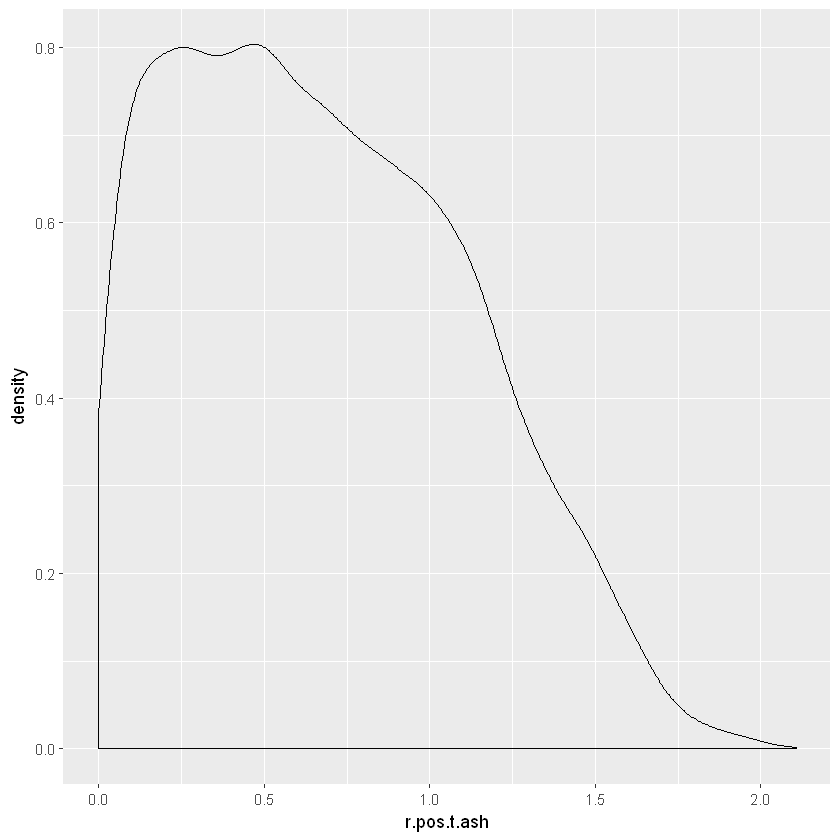

In [11]:
r.pos.t.ash = asinh(r.pos)

# find new skewness to test change
print(paste("skewness: ",
            skewness(r.pos.t.ash)))

# plot histogram to see the change
qplot(r.pos.t.ash, geom = "density")

[1] "skewness:  -0.426011790523362"


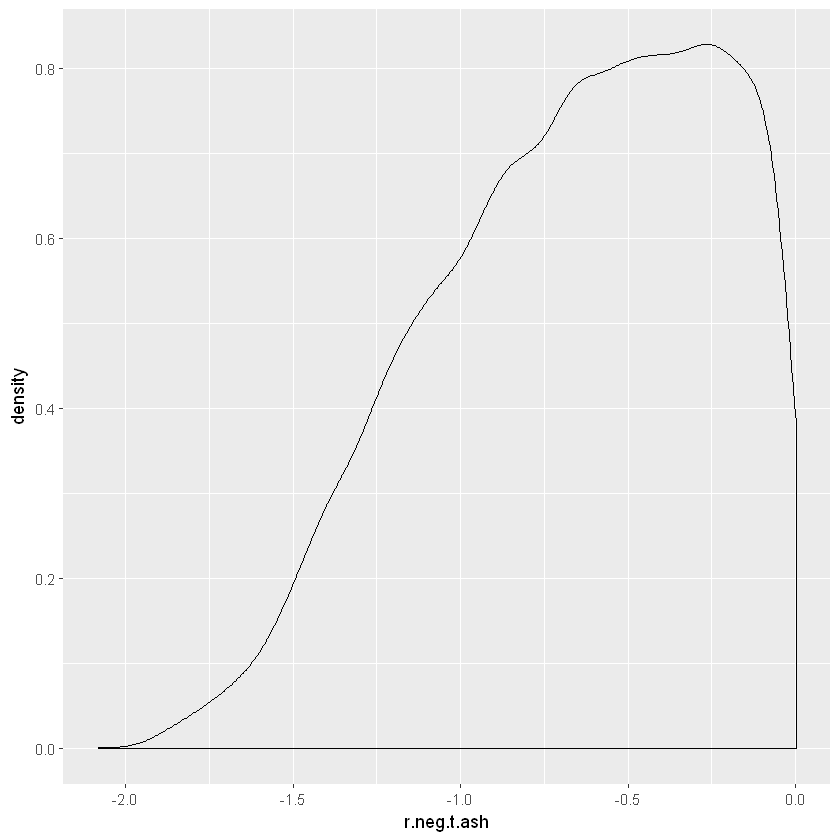

In [12]:
r.neg.t.ash = asinh(r.neg)

# find new skewness to test change
print(paste("skewness: ",
            skewness(r.neg.t.ash)))

# plot histogram to see the change
qplot(r.neg.t.ash, geom = "density")

This works too. It doesn't appear as effective as the other transformations, but does apply to every case. This too can be addressed, using a tuning parameter, $\theta$, to adjust the effectiveness of the transformation:

$$ x_{new} = \frac{arcsinh(\theta x)}{\theta} $$

With the derivative:

$$ \frac{dy}{dx} = \frac{1}{\sqrt{\theta^2x^2 + 1}} $$

Still, we gain computational effectiveness, but at the cost of easy interpretability.


Who wants to explain these to the guys and gals in the C-suite?

Want to read more? Go here: http://fmwww.bc.edu/repec/bocode/t/transint.html